In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
from datetime import datetime
from collections import namedtuple

In [2]:
mypath = r"Stats"
onlyfiles = [f for f in os.listdir(mypath) if os.path.isfile(os.path.join(mypath, f))]

print(onlyfiles)

['atpqp_Profile-Visual+Weste+Thermal+Sound_22_12_16__13_36.csv', 'atpqp_Profile-Visual+Weste+Thermal_22_12_16__14_34.csv', 'atpqp_Profile-Visual+Weste_22_12_16__14_18.csv', 'atpqp_Profile-Visual_22_12_16__14_01.csv', 'auffz_Profile-Visual+Weste+Thermal+Sound_22_12_07__15_09.csv', 'auffz_Profile-Visual+Weste+Thermal_22_12_07__14_53.csv', 'auffz_Profile-Visual+Weste_22_12_07__14_27.csv', 'auffz_Profile-Visual+Weste_22_12_07__14_32.csv', 'auffz_Profile-Visual_22_12_07__14_08.csv', 'dycnh_Profile-Visual+Weste+Thermal+Sound_22_11_30__22_52.csv', 'dycnh_Profile-Visual+Weste+Thermal_22_11_30__22_32.csv', 'dycnh_Profile-Visual+Weste_22_11_30__22_21.csv', 'dycnh_Profile-Visual_22_11_30__22_03.csv', 'easva_Profile-Visual+Weste+Thermal+Sound_22_12_16__12_23.csv', 'easva_Profile-Visual+Weste+Thermal_22_12_16__11_54.csv', 'easva_Profile-Visual+Weste_22_12_16__12_55.csv', 'easva_Profile-Visual_22_12_16__12_41.csv', 'hnkgs_Profile-Visual+Weste+Thermal+Sound_22_12_09__13_30.csv', 'hnkgs_Profile-Visual

In [3]:
# This isn't dynamic, I don't care it doesn't matter
ABCD_playertags = ["dycnh", "juheo", "auffz"]
BCDA_playertags = ["lnlqi","zegfw"]
CDAB_playertags = ["yicwd", "easva"]
DABC_playertags = ["hnkgs","twkfm", "atpqp"]

short_name = {"Profile-Visual": "A", "Profile-Visual+Weste" : "B", "Profile-Visual+Weste+Thermal" : "C", "Profile-Visual+Weste+Thermal+Sound" : "D"}
played_first = {"A": ABCD_playertags, "B":BCDA_playertags, "C": CDAB_playertags, "D": DABC_playertags}

In [4]:
#df = pd.read_csv(os.path.join(mypath, onlyfiles[0]))

def condenseStats(file, loud = False):
    
    stats_dict = {}
    
    df = pd.read_csv(os.path.join(mypath, file))
    #preprocess gametime
    
    stats_dict["player_tag"] = df["Player"][0]
    stats_dict["profile"] = df["Profile"][0]
    
    t = np.array(df["Time"], )
    t = t.astype(datetime)

    t = np.array([datetime.strptime(my_date_string, '%Y-%m-%d %H:%M:%S.%f') for my_date_string in t])

    start_time = t[0]
    t = t - start_time

    t = np.array([int(timesince.total_seconds()) for timesince in t]) 
    df["GameTime"] = t
    
    time_played = t[-1]
    time_played_min = time_played / 60
    
    stats_dict["time_played_sec"] = time_played
    stats_dict["time_played_min"] = time_played_min
    if loud:
        print(f"time played {time_played} seconds. {time_played_min} minutes")
        print("\nplayer damaging enemies")
        
    events= ("killed an enemy", "enemy_headshot")
    for e in events:
        df_event = df.loc[df["Event"]==e]
        stats_dict[e+"_total"]=len(df_event)
        stats_dict[e+"_per_minute"]=len(df_event)/time_played_min
        if loud:
            print(e, len(df_event), "  |  ", len(df_event)/time_played_min, " per minute")
        
    df_event = df.loc[df["Event"].str.contains("weapon_fired", case = False)]
    stats_dict["weapon_fired_total"] = len(df_event)
    stats_dict["weapon_fired_per_minute"] = len(df_event)/time_played_min
    if loud:
        print("weapon_fired", len(df_event), "  |  ", len(df_event)/time_played_min)
    l = np.array(df_event["Event"])
    l = np.array([st.split(" ")[-1] for st in l], int).astype(int)
    stats_dict["hits_total"] = l.sum()
    stats_dict["hits_per_minute"] = l.sum()/time_played_min
    stats_dict["accuracy"] = l.sum()/len(df_event)
    if loud:
        print("hits",l.sum(),  "  |  ", l.sum()/time_played_min, " per minute")
        print("accuracy is ", l.sum()/len(df_event))
    
    
        print("\nplayer taking damage")
    
    events= ("shielded hit", "unshielded hit", "tased", "auto regenerate armor", "auto replenish health", "downed", "revived by ally")
    for e in events:
        df_event = df.loc[df["Event"]==e]
        stats_dict[e+"_total"] = len(df_event)
        stats_dict[e+"_per_minute"]=len(df_event)/time_played_min
        if loud:
            print(e, len(df_event),  "  |  ", len(df_event)/time_played_min, " per minute")
    
    
    eventContains = ("complete_objective", "activate_objective")
    for e in eventContains:
        df_event = df.loc[df["Event"].str.contains(e, case = False)]
        stats_dict[e+"_total"] = len(df_event)
        stats_dict[e+"_per_minute"]=len(df_event)/time_played_min
        if loud:
            print(e, len(df_event), "  |  ", len(df_event)/time_played_min, " per minute")
        
    # average hp value
    
    df_hp = df.loc[df["Event"].str.contains("hp", case = False)]
    hp = np.array([int(ev.replace("hp ","")) for ev in df_hp["Event"]])
    hp_max = np.max(hp)
    #hp = hp/hp_max
    stats_dict["average_hp"]=np.average(hp)
    if loud:
        print(f"average Hp is {np.average(hp)}")
        
    # player armor
    df_armor = df.loc[df["Event"].str.contains("armor", case = False)]
    df_armor = df_armor.loc[~df_armor["Event"].str.contains("regenerate armor", case = False)]
    armor = np.array([int(ev.replace("armor ","")) for ev in df_armor["Event"]])
    armor_max = np.max(armor)
    #armor = armor/armor_max
    stats_dict["average_armor"]= np.average(armor)
    if loud:
        print(f"Average Armor is {np.average(armor)}")
    
    # total health lost
    
    def total_value_lost(li):
        peak = li[0]
        valley = li[0]
        last = li[0]
        climbing = True
        
        lost = 0
        
        for val in li:
            #print(val)
            if climbing:
                if last <= val: # going up
                    peak = val # finding value of peak
                else: #last >= val going down
                    valley = val 
                    climbing = False
                    # we switch direction. peak found
            else:
                if last >= val:
                    valley = val # finding value of valley
                else:
                    # found a valley. next climb again
                    lost = lost + (peak - valley)
                    #print(f"found valley peak: {peak} valley: {valley}. total now: {lost}")
                    peak = val
                    climbing = True
            last = val
        return lost
            
    #print(f"total hp lost {total_value_lost(hp)}   |    {total_value_lost(hp)/time_played_min}")
    stats_dict["armor_lost_total"] = total_value_lost(armor)
    stats_dict["armor_lost_per_min"] = total_value_lost(armor)/time_played_min
    if loud:
        print(f"total armor lost {total_value_lost(armor)}    |     {total_value_lost(armor)/time_played_min} per minute")
    
    #fig, ax=plt.subplots(figsize=(15,10))
    #ax.plot(df_hp["GameTime"], hp, label="hp", linewidth=4.0, color='orange')
    
    hp_lost = df.loc[df["Event"].str.contains("health_subtracted", case = False)]
    hp_lost = np.array([float(ev.replace("health_subtracted ","")) for ev in hp_lost["Event"]])
    stats_dict["hp_lost_total"] = int(np.sum(hp_lost)*10)
    stats_dict["hp_lost_per_minute"] = int(np.sum(hp_lost)*10) / time_played_min
    if loud:
        print(f"total hp lost {int(np.sum(hp_lost)*10)}     |     {int(np.sum(hp_lost)*10) / time_played_min} per minute")
    
    # how much time spend on full armor?
    
    armor_time = np.array(df_armor["GameTime"])
    
    def time_spent_at_max_value(values, time, max_value, starts_with_interval):
        #print(f"\nfinding time spend at max value {max_value}")
        interval_start = 0
        end_time = 0
        is_max_val = starts_with_interval
        total_max_val_time = 0
        interval_entries= 0
        for val, t in zip(values,time):
            #print(f"{t} : {val}")
            if is_max_val:
                if val == max_value:
                    end_time = t
                    #print(f"{t} is max, extending interval")
                else:
                    total_max_val_time = total_max_val_time + ( end_time - interval_start )
                    #print(f"{t} end of interval found. {end_time} - {interval_start}")
                    interval_start = t
                    end_time = t
                    is_max_val = False
            else:
                if val == max_value:
                    #print(f"{t} starting interval {val}")
                    interval_start = t
                    end_time = t
                    is_max_val = True
                    interval_entries = interval_entries + 1
                #else:
                    #print(f"{t} is not max, no interval")
        #print(f"interval_entires {interval_entries}")
        return total_max_val_time
                    
    total_max_armor_time = time_spent_at_max_value(armor, armor_time, armor_max, True)
    stats_dict["time_spend_with_max_armor"] = total_max_armor_time
    stats_dict["time_spend_with_max_armor_percentage"] = (total_max_armor_time / time_played)* 100
    if loud:
        print(f"time spend with max armor : {total_max_armor_time}    |      {(total_max_armor_time / time_played)* 100} % of the game")
    
    # time spent crouching
    df_crouching = df.loc[df["Event"].str.contains("stance_crouched", case = False)]
    crouching = np.array([int (ev.replace("stance_crouched ","")) for ev in df_crouching["Event"]])
    crouching_time = np.array(df_crouching["GameTime"])
    total_crouching_time = time_spent_at_max_value(crouching, crouching_time, 1, False)
    stats_dict["time_spend_crouched"] = total_crouching_time
    stats_dict["time_spend_crouched_percentage"] = (total_crouching_time / time_played) * 100
    if loud:
        print(f"time spend crouched: {total_crouching_time}      |     {(total_crouching_time / time_played) * 100} % of the game")
    
    return stats_dict

#condenseStats("atpqp_Profile-Visual+Weste+Thermal+Sound_22_12_16__13_36.csv")

In [5]:
stats_df = pd.DataFrame()
stats_df["stat"] = condenseStats(onlyfiles[0]).keys()
for f in onlyfiles:
    stats_dict = condenseStats(f)
    #print(stats_dict.values())
    stats_df[stats_dict["player_tag"]+" "+ stats_dict["profile"]] = stats_dict.values()
stats_df

,stat,atpqp Profile-Visual+Weste+Thermal+Sound,atpqp Profile-Visual+Weste+Thermal,atpqp Profile-Visual+Weste,atpqp Profile-Visual,auffz Profile-Visual+Weste+Thermal+Sound,auffz Profile-Visual+Weste+Thermal,auffz Profile-Visual+Weste,auffz Profile-Visual,dycnh Profile-Visual+Weste+Thermal+Sound,...,twkfm Profile-Visual+Weste,twkfm Profile-Visual,yicwd Profile-Visual+Weste+Thermal+Sound,yicwd Profile-Visual+Weste+Thermal,yicwd Profile-Visual+Weste,yicwd Profile-Visual,zegfw Profile-Visual+Weste+Thermal+Sound,zegfw Profile-Visual+Weste+Thermal,zegfw Profile-Visual+Weste,zegfw Profile-Visual
0,player_tag,atpqp,atpqp,atpqp,atpqp,auffz,auffz,auffz,auffz,dycnh,...,twkfm,twkfm,yicwd,yicwd,yicwd,yicwd,zegfw,zegfw,zegfw,zegfw
1,profile,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,...,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual,Profile-Visual+Weste+Thermal+Sound,Profile-Visual+Weste+Thermal,Profile-Visual+Weste,Profile-Visual
2,time_played_sec,942,751,818,907,819,699,814,930,738,...,744,730,643,768,740,790,861,964,1106,903
3,time_played_min,15.7,12.516667,13.633333,15.116667,13.65,11.65,13.566667,15.5,12.3,...,12.4,12.166667,10.716667,12.8,12.333333,13.166667,14.35,16.066667,18.433333,15.05
4,killed an enemy_total,118,75,80,117,139,103,132,112,112,...,141,135,80,97,99,86,160,173,158,149
5,killed an enemy_per_minute,7.515924,5.992011,5.867971,7.739802,10.18315,8.841202,9.72973,7.225806,9.105691,...,11.370968,11.09589,7.465008,7.578125,8.027027,6.531646,11.149826,10.767635,8.571429,9.900332
6,enemy_headshot_total,50,23,30,37,39,34,33,36,68,...,42,42,60,72,77,71,44,46,36,40
7,enemy_headshot_per_minute,3.184713,1.83755,2.200489,2.44763,2.857143,2.918455,2.432432,2.322581,5.528455,...,3.387097,3.452055,5.598756,5.625,6.243243,5.392405,3.066202,2.863071,1.952984,2.657807
8,weapon_fired_total,1034,646,716,1094,1739,1187,1439,1338,532,...,977,769,248,337,332,305,1626,1688,1516,1651
9,weapon_fired_per_minute,65.859873,51.611185,52.518337,72.370452,127.399267,101.888412,106.068796,86.322581,43.252033,...,78.790323,63.205479,23.141524,26.328125,26.918919,23.164557,113.310105,105.062241,82.242315,109.700997


In [6]:
# join all the versions, ignores which one was started with
#https://thispointer.com/pandas-select-columns-based-on-conditions-in-dataframe/
averages_df = pd.DataFrame()
averages_df["stat"] = stats_df["stat"].drop([0,1])

for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
    filter_ = (stats_df == p).any()
    sub_df = stats_df.loc[:,filter_]
    sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
    mean_df = sub_df.mean(axis = 1)
    averages_df[short_name[p]] = mean_df
    
    std_df = sub_df.std(axis = 1)
    averages_df[short_name[p]+" std"] = std_df


averages_df



,stat,A,A std,B,B std,C,C std,D,D std
2,time_played_sec,831.800000,103.565116,805.700000,159.571684,900.000000,321.514817,822.000000,139.426604
3,time_played_min,13.863333,1.726085,13.428333,2.659528,15.000000,5.358580,13.700000,2.323777
4,killed an enemy_total,104.700000,36.279930,106.800000,30.943676,127.400000,42.792003,108.500000,28.659883
5,killed an enemy_per_minute,7.451449,2.302822,8.010855,1.881799,8.695579,2.255767,7.984099,1.915439
6,enemy_headshot_total,40.500000,14.751648,40.400000,16.466802,50.200000,22.109827,45.000000,15.048071
7,enemy_headshot_per_minute,2.927941,1.079049,3.149834,1.464364,3.554202,1.463997,3.438730,1.400971
8,weapon_fired_total,878.200000,441.838281,880.800000,392.558785,1070.700000,518.934389,933.100000,478.926914
9,weapon_fired_per_minute,61.811651,27.027142,64.944204,23.795121,70.559425,25.035037,66.491361,31.631841
10,hits_total,128.900000,46.524665,129.600000,36.920937,159.500000,61.458658,132.000000,42.347767
11,hits_per_minute,9.164431,2.861885,9.723309,2.232646,10.731222,2.854233,9.643296,2.748077


In [7]:
# as first version played

averages_df = pd.DataFrame()
averages_df["stat"] = stats_df["stat"].drop([0,1])

for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
    filter_ = (stats_df == p).any() # get every session with profile p
    sub_df = stats_df.loc[:,filter_]
    
    players_who_played_version_first = played_first[short_name[p]]
    print(p,players_who_played_version_first)
    starts_with_this_profile_filter = (sub_df == players_who_played_version_first[0]).any()
    for i in range(1,len(players_who_played_version_first)):
        starts_with_this_profile_filter = starts_with_this_profile_filter | (sub_df == players_who_played_version_first[i]).any()
    sub_df = sub_df.loc[:,starts_with_this_profile_filter]
    
    #print(sub_df)
    sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
    mean_df = sub_df.mean(axis = 1)
    averages_df["1"+short_name[p]] = mean_df
    
    std_df = sub_df.std(axis = 1)
    averages_df["1"+short_name[p]+" std"] = std_df


averages_df


Profile-Visual ['dycnh', 'juheo', 'auffz']
Profile-Visual+Weste ['lnlqi', 'zegfw']
Profile-Visual+Weste+Thermal ['yicwd', 'easva']
Profile-Visual+Weste+Thermal+Sound ['hnkgs', 'twkfm', 'atpqp']


,stat,1A,1A std,1B,1B std,1C,1C std,1D,1D std
2,time_played_sec,939.666667,26.839026,1007.000000,140.007143,1073.000000,431.335137,825.666667,128.958650
3,time_played_min,15.661111,0.447317,16.783333,2.333452,17.883333,7.188919,13.761111,2.149311
4,killed an enemy_total,124.000000,18.248288,118.000000,56.568542,145.500000,68.589358,110.000000,23.065125
5,killed an enemy_per_minute,7.935340,1.327484,6.862807,2.416356,8.012575,0.614405,7.969591,0.945658
6,enemy_headshot_total,45.000000,10.148892,25.500000,14.849242,85.500000,19.091883,50.000000,7.000000
7,enemy_headshot_per_minute,2.879507,0.693402,1.472087,0.680091,4.967798,0.929425,3.657730,0.432514
8,weapon_fired_total,1077.666667,347.549037,1175.500000,481.539718,963.500000,886.004797,881.000000,195.317690
9,weapon_fired_per_minute,69.233164,23.645461,68.709263,19.138625,47.779447,30.336751,63.554867,5.081606
10,hits_total,151.000000,28.354894,149.500000,67.175144,171.000000,108.894444,131.666667,24.785749
11,hits_per_minute,9.674642,2.046332,8.713625,2.791002,9.071004,2.442706,9.576317,1.170943


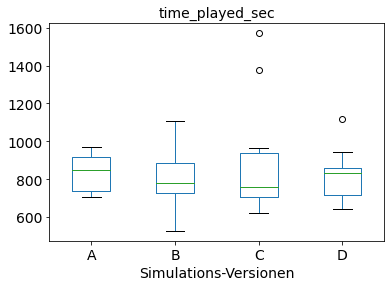

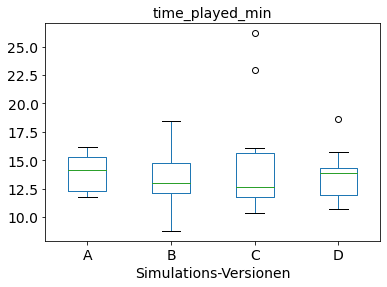

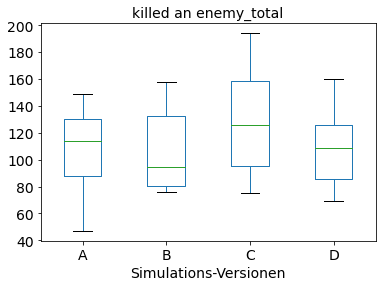

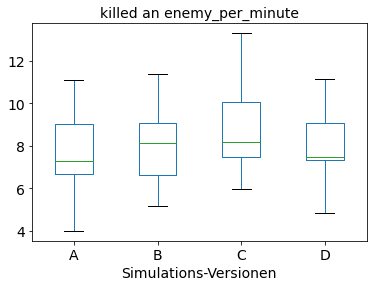

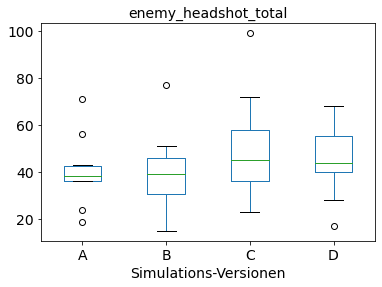

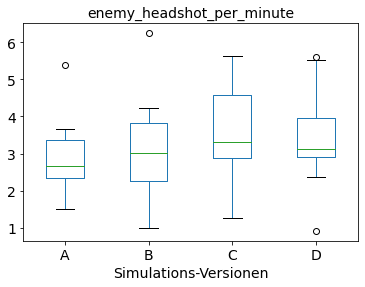

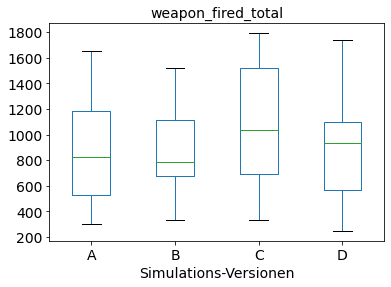

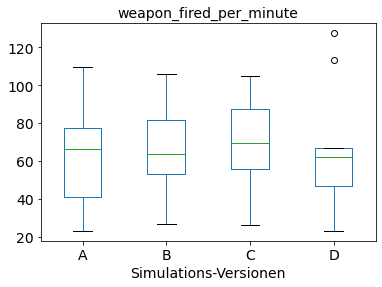

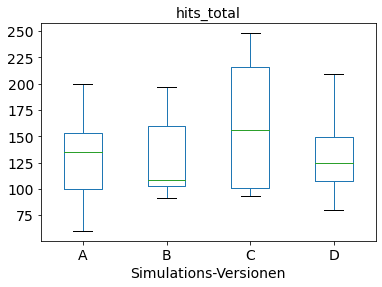

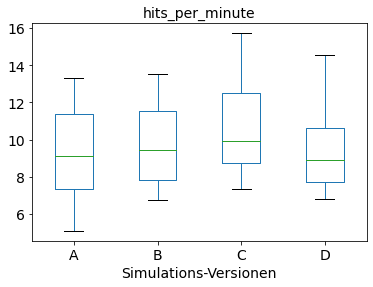

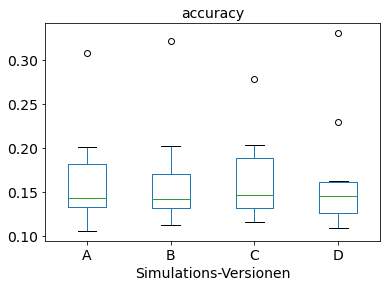

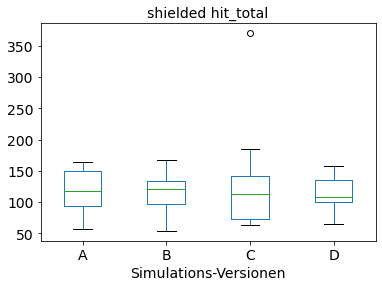

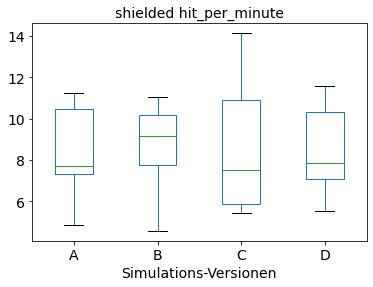

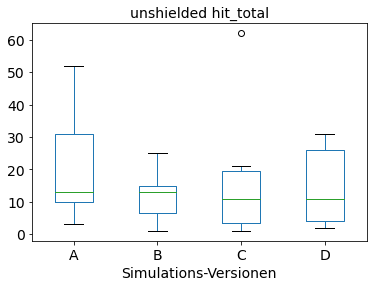

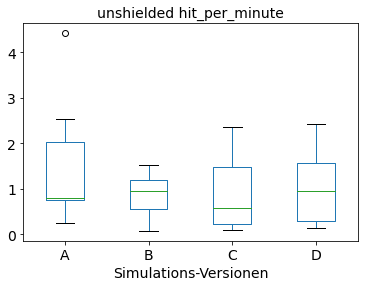

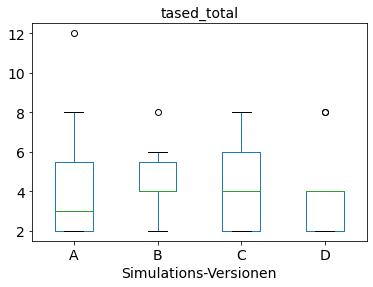

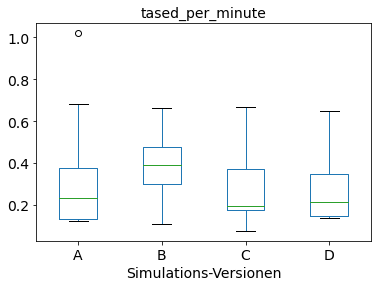

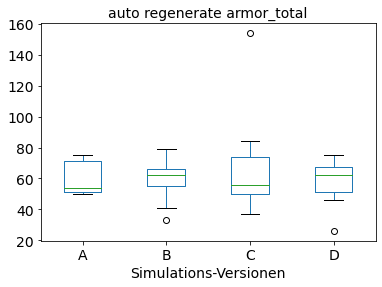

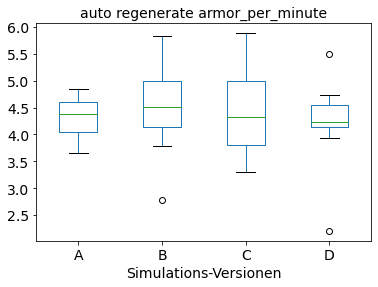

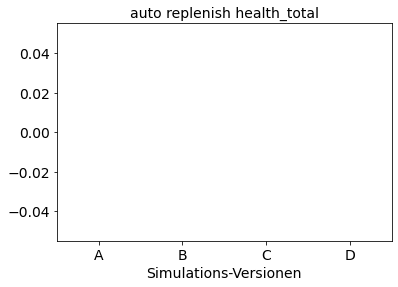

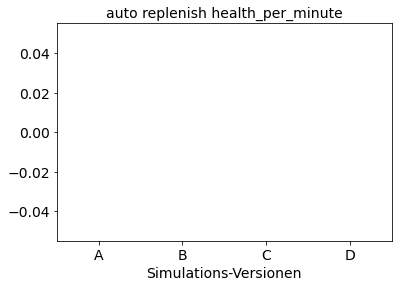

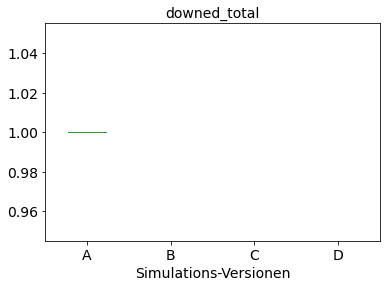

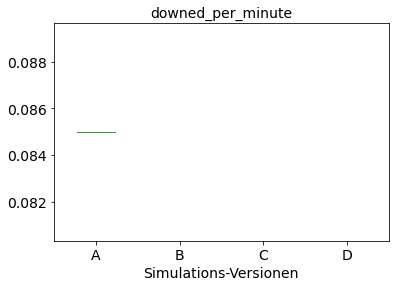

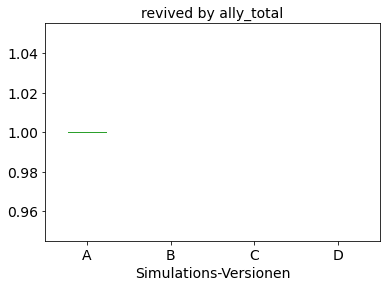

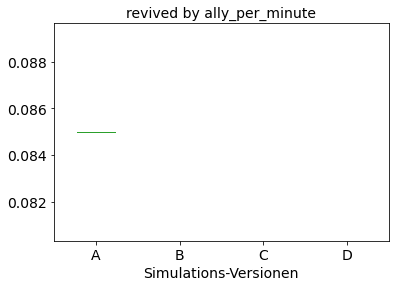

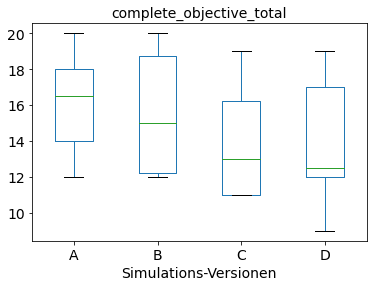

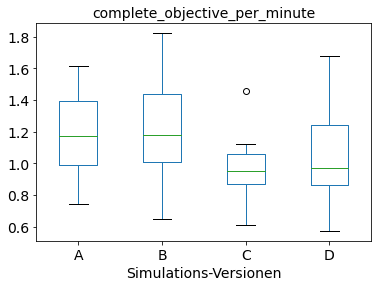

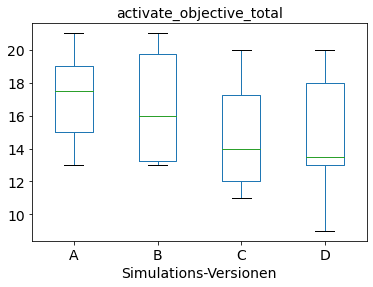

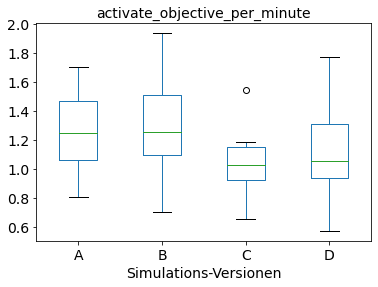

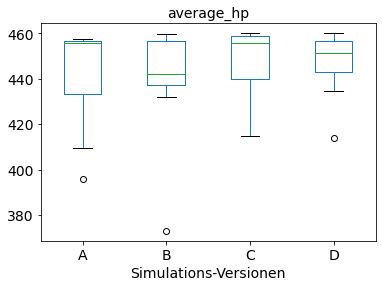

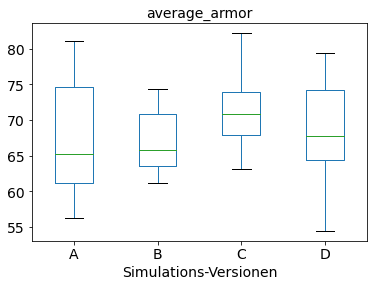

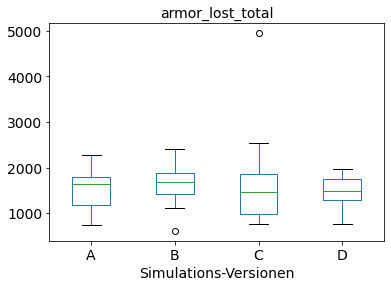

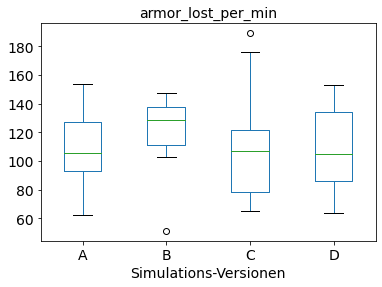

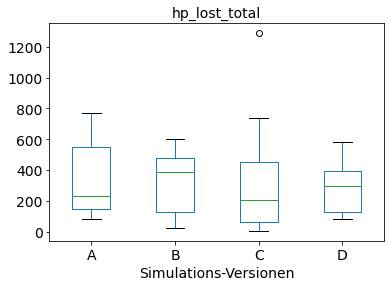

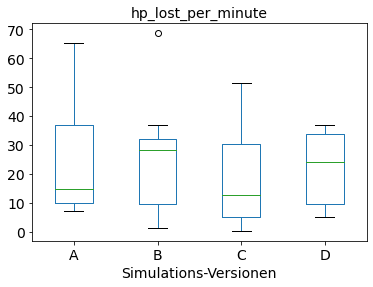

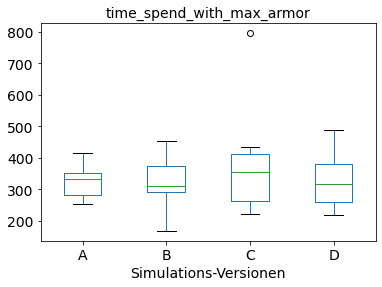

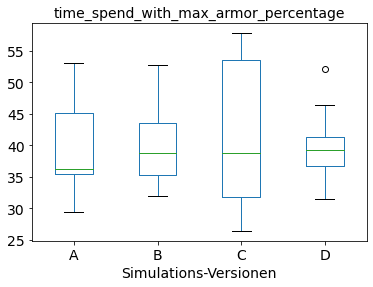

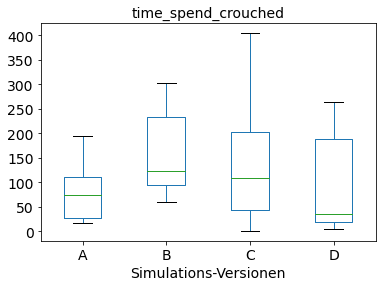

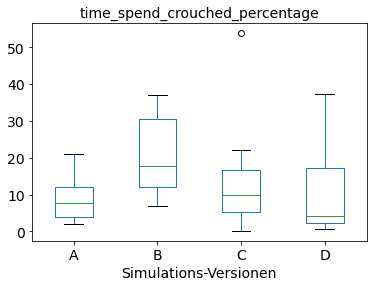

In [8]:

def plot(my_df, stat_name = "time_spend_crouched"):
    stat_by_profile = pd.DataFrame()
    
    for p in ["Profile-Visual", "Profile-Visual+Weste", "Profile-Visual+Weste+Thermal", "Profile-Visual+Weste+Thermal+Sound"]:
        filter_ = (stats_df == p).any()
        sub_df = stats_df.loc[:,filter_]
        sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
        # sub_df contains all playsessions of profile p

        row_of_stat = sub_df.loc[my_df["stat"]==stat_name] # get just the row for the stat we want to visualize
        column_of_stat = row_of_stat.transpose()
        l = np.array(column_of_stat[column_of_stat.columns[0]])
        stat_by_profile[short_name[p]] = l
        #print(stat_by_profile)
        
    ax = stat_by_profile.mask(stat_by_profile == 0).plot.box(fontsize = 14,)
    

    plt.suptitle('')
    ax.set_title(stat_name, fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    ax = plt.show()

#print(stats_df["stat"])
for stat in list(stats_df["stat"].drop([0,1])):
    plot(stats_df,stat)

                        2
atpqp Profile-Visual  907
hnkgs Profile-Visual  706
twkfm Profile-Visual  730
                                            2
atpqp Profile-Visual+Weste+Thermal+Sound  942
hnkgs Profile-Visual+Weste+Thermal+Sound  687
twkfm Profile-Visual+Weste+Thermal+Sound  848


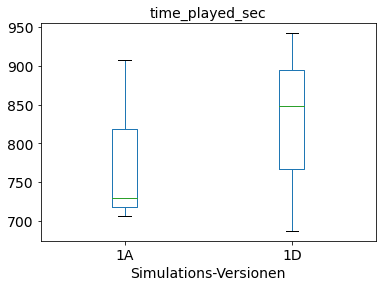

,1A,1D
0,907,942
1,706,687
2,730,848


                              3
atpqp Profile-Visual  15.116667
hnkgs Profile-Visual  11.766667
twkfm Profile-Visual  12.166667
                                                  3
atpqp Profile-Visual+Weste+Thermal+Sound       15.7
hnkgs Profile-Visual+Weste+Thermal+Sound      11.45
twkfm Profile-Visual+Weste+Thermal+Sound  14.133333


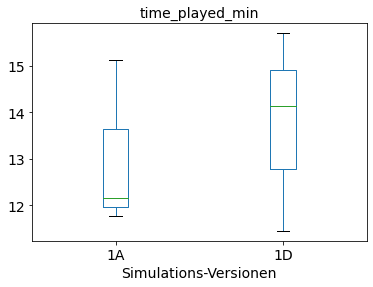

,1A,1D
0,15.116667,15.7
1,11.766667,11.45
2,12.166667,14.133333


                        4
atpqp Profile-Visual  117
hnkgs Profile-Visual   48
twkfm Profile-Visual  135
                                            4
atpqp Profile-Visual+Weste+Thermal+Sound  118
hnkgs Profile-Visual+Weste+Thermal+Sound   84
twkfm Profile-Visual+Weste+Thermal+Sound  128


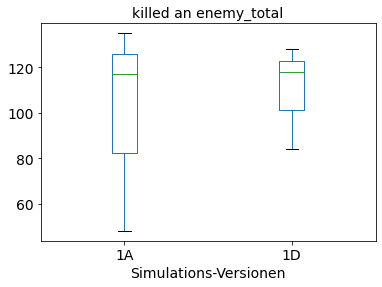

,1A,1D
0,117,118
1,48,84
2,135,128


                             5
atpqp Profile-Visual  7.739802
hnkgs Profile-Visual   4.07932
twkfm Profile-Visual  11.09589
                                                 5
atpqp Profile-Visual+Weste+Thermal+Sound  7.515924
hnkgs Profile-Visual+Weste+Thermal+Sound  7.336245
twkfm Profile-Visual+Weste+Thermal+Sound  9.056604


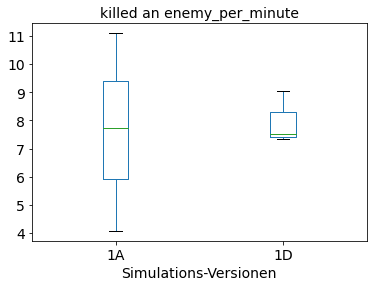

,1A,1D
0,7.739802,7.515924
1,4.07932,7.336245
2,11.09589,9.056604


                       6
atpqp Profile-Visual  37
hnkgs Profile-Visual  37
twkfm Profile-Visual  42
                                           6
atpqp Profile-Visual+Weste+Thermal+Sound  50
hnkgs Profile-Visual+Weste+Thermal+Sound  43
twkfm Profile-Visual+Weste+Thermal+Sound  57


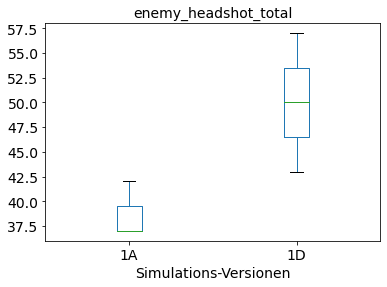

,1A,1D
0,37,50
1,37,43
2,42,57


                             7
atpqp Profile-Visual   2.44763
hnkgs Profile-Visual  3.144476
twkfm Profile-Visual  3.452055
                                                 7
atpqp Profile-Visual+Weste+Thermal+Sound  3.184713
hnkgs Profile-Visual+Weste+Thermal+Sound  3.755459
twkfm Profile-Visual+Weste+Thermal+Sound  4.033019


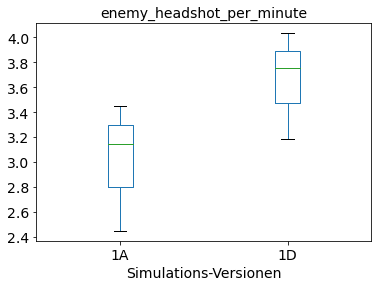

,1A,1D
0,2.44763,3.184713
1,3.144476,3.755459
2,3.452055,4.033019


                         8
atpqp Profile-Visual  1094
hnkgs Profile-Visual   379
twkfm Profile-Visual   769
                                             8
atpqp Profile-Visual+Weste+Thermal+Sound  1034
hnkgs Profile-Visual+Weste+Thermal+Sound   661
twkfm Profile-Visual+Weste+Thermal+Sound   948


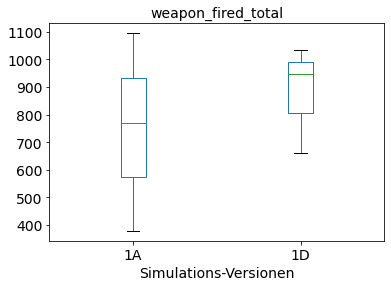

,1A,1D
0,1094,1034
1,379,661
2,769,948


                              9
atpqp Profile-Visual  72.370452
hnkgs Profile-Visual  32.209632
twkfm Profile-Visual  63.205479
                                                  9
atpqp Profile-Visual+Weste+Thermal+Sound  65.859873
hnkgs Profile-Visual+Weste+Thermal+Sound  57.729258
twkfm Profile-Visual+Weste+Thermal+Sound  67.075472


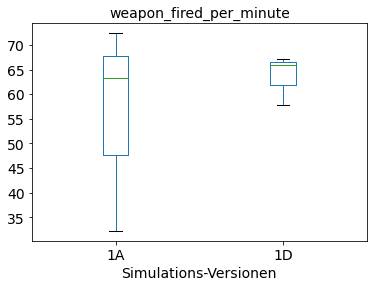

,1A,1D
0,72.370452,65.859873
1,32.209632,57.729258
2,63.205479,67.075472


                       10
atpqp Profile-Visual  147
hnkgs Profile-Visual   60
twkfm Profile-Visual  155
                                           10
atpqp Profile-Visual+Weste+Thermal+Sound  136
hnkgs Profile-Visual+Weste+Thermal+Sound  105
twkfm Profile-Visual+Weste+Thermal+Sound  154


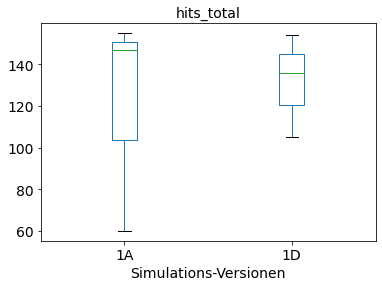

,1A,1D
0,147,136
1,60,105
2,155,154


                             11
atpqp Profile-Visual   9.724366
hnkgs Profile-Visual    5.09915
twkfm Profile-Visual  12.739726
                                                 11
atpqp Profile-Visual+Weste+Thermal+Sound    8.66242
hnkgs Profile-Visual+Weste+Thermal+Sound   9.170306
twkfm Profile-Visual+Weste+Thermal+Sound  10.896226


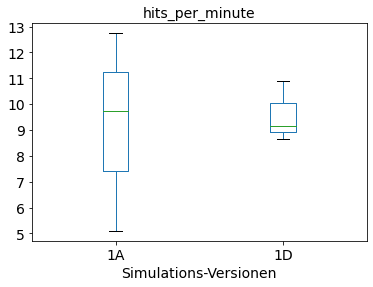

,1A,1D
0,9.724366,8.66242
1,5.09915,9.170306
2,12.739726,10.896226


                            12
atpqp Profile-Visual  0.134369
hnkgs Profile-Visual  0.158311
twkfm Profile-Visual   0.20156
                                                12
atpqp Profile-Visual+Weste+Thermal+Sound  0.131528
hnkgs Profile-Visual+Weste+Thermal+Sound   0.15885
twkfm Profile-Visual+Weste+Thermal+Sound  0.162447


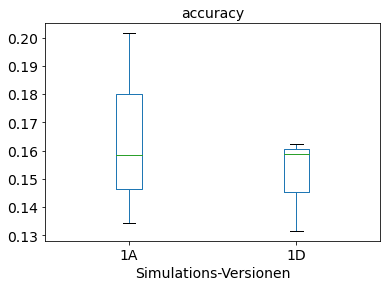

,1A,1D
0,0.134369,0.131528
1,0.158311,0.15885
2,0.20156,0.162447


                       13
atpqp Profile-Visual  115
hnkgs Profile-Visual  132
twkfm Profile-Visual   87
                                           13
atpqp Profile-Visual+Weste+Thermal+Sound  110
hnkgs Profile-Visual+Weste+Thermal+Sound  105
twkfm Profile-Visual+Weste+Thermal+Sound  102


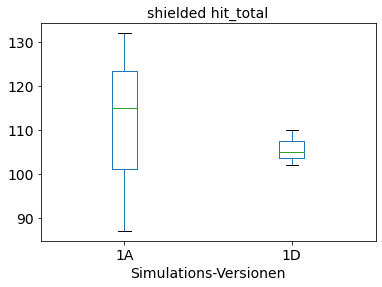

,1A,1D
0,115,110
1,132,105
2,87,102


                            14
atpqp Profile-Visual  7.607497
hnkgs Profile-Visual  11.21813
twkfm Profile-Visual  7.150685
                                                14
atpqp Profile-Visual+Weste+Thermal+Sound  7.006369
hnkgs Profile-Visual+Weste+Thermal+Sound  9.170306
twkfm Profile-Visual+Weste+Thermal+Sound  7.216981


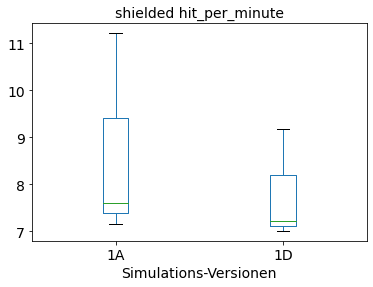

,1A,1D
0,7.607497,7.006369
1,11.21813,9.170306
2,7.150685,7.216981


                      15
atpqp Profile-Visual  15
hnkgs Profile-Visual  52
twkfm Profile-Visual   3
                                          15
atpqp Profile-Visual+Weste+Thermal+Sound   4
hnkgs Profile-Visual+Weste+Thermal+Sound  11
twkfm Profile-Visual+Weste+Thermal+Sound   4


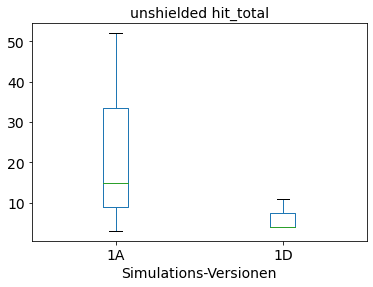

,1A,1D
0,15,4
1,52,11
2,3,4


                            16
atpqp Profile-Visual  0.992282
hnkgs Profile-Visual  4.419263
twkfm Profile-Visual  0.246575
                                                16
atpqp Profile-Visual+Weste+Thermal+Sound  0.254777
hnkgs Profile-Visual+Weste+Thermal+Sound  0.960699
twkfm Profile-Visual+Weste+Thermal+Sound  0.283019


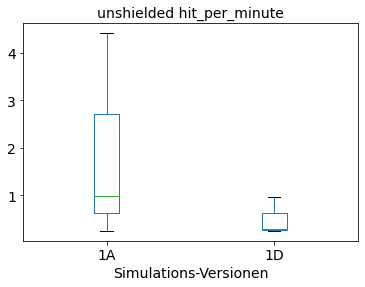

,1A,1D
0,0.992282,0.254777
1,4.419263,0.960699
2,0.246575,0.283019


                      17
atpqp Profile-Visual   2
hnkgs Profile-Visual  12
twkfm Profile-Visual   2
                                         17
atpqp Profile-Visual+Weste+Thermal+Sound  8
hnkgs Profile-Visual+Weste+Thermal+Sound  4
twkfm Profile-Visual+Weste+Thermal+Sound  2


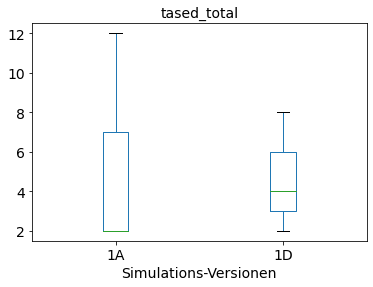

,1A,1D
0,2,8
1,12,4
2,2,2


                            18
atpqp Profile-Visual  0.132304
hnkgs Profile-Visual   1.01983
twkfm Profile-Visual  0.164384
                                                18
atpqp Profile-Visual+Weste+Thermal+Sound  0.509554
hnkgs Profile-Visual+Weste+Thermal+Sound  0.349345
twkfm Profile-Visual+Weste+Thermal+Sound  0.141509


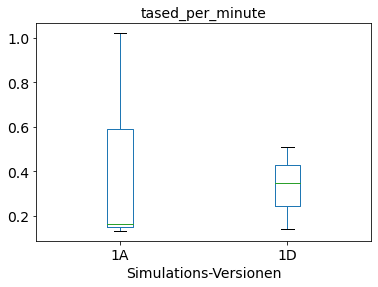

,1A,1D
0,0.132304,0.509554
1,1.01983,0.349345
2,0.164384,0.141509


                      19
atpqp Profile-Visual  70
hnkgs Profile-Visual  51
twkfm Profile-Visual  52
                                          19
atpqp Profile-Visual+Weste+Thermal+Sound  65
hnkgs Profile-Visual+Weste+Thermal+Sound  52
twkfm Profile-Visual+Weste+Thermal+Sound  59


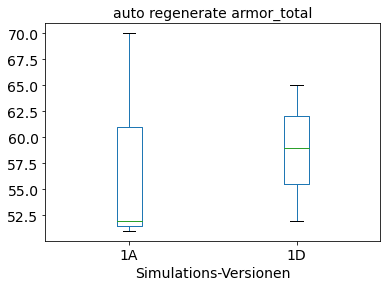

,1A,1D
0,70,65
1,51,52
2,52,59


                            20
atpqp Profile-Visual   4.63065
hnkgs Profile-Visual  4.334278
twkfm Profile-Visual  4.273973
                                                20
atpqp Profile-Visual+Weste+Thermal+Sound  4.140127
hnkgs Profile-Visual+Weste+Thermal+Sound  4.541485
twkfm Profile-Visual+Weste+Thermal+Sound  4.174528


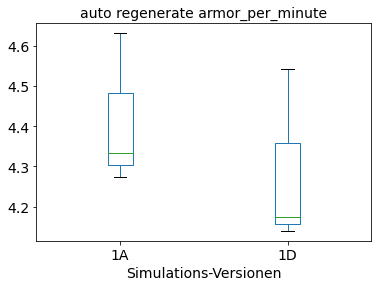

,1A,1D
0,4.63065,4.140127
1,4.334278,4.541485
2,4.273973,4.174528


                     21
atpqp Profile-Visual  0
hnkgs Profile-Visual  0
twkfm Profile-Visual  0
                                         21
atpqp Profile-Visual+Weste+Thermal+Sound  0
hnkgs Profile-Visual+Weste+Thermal+Sound  0
twkfm Profile-Visual+Weste+Thermal+Sound  0


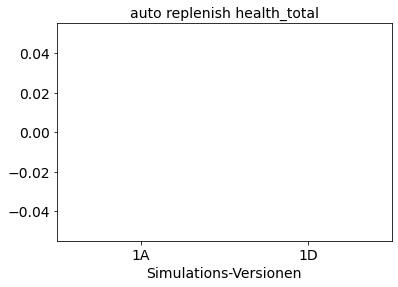

,1A,1D
0,0,0
1,0,0
2,0,0


                       22
atpqp Profile-Visual  0.0
hnkgs Profile-Visual  0.0
twkfm Profile-Visual  0.0
                                           22
atpqp Profile-Visual+Weste+Thermal+Sound  0.0
hnkgs Profile-Visual+Weste+Thermal+Sound  0.0
twkfm Profile-Visual+Weste+Thermal+Sound  0.0


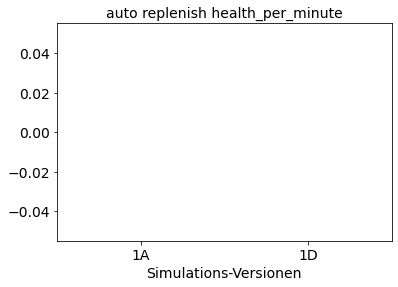

,1A,1D
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0


                     23
atpqp Profile-Visual  0
hnkgs Profile-Visual  1
twkfm Profile-Visual  0
                                         23
atpqp Profile-Visual+Weste+Thermal+Sound  0
hnkgs Profile-Visual+Weste+Thermal+Sound  0
twkfm Profile-Visual+Weste+Thermal+Sound  0


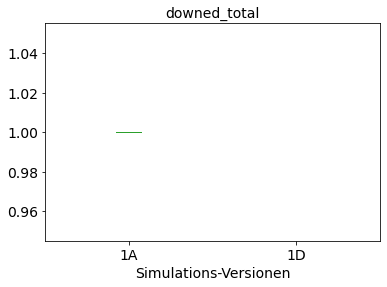

,1A,1D
0,0,0
1,1,0
2,0,0


                            24
atpqp Profile-Visual       0.0
hnkgs Profile-Visual  0.084986
twkfm Profile-Visual       0.0
                                           24
atpqp Profile-Visual+Weste+Thermal+Sound  0.0
hnkgs Profile-Visual+Weste+Thermal+Sound  0.0
twkfm Profile-Visual+Weste+Thermal+Sound  0.0


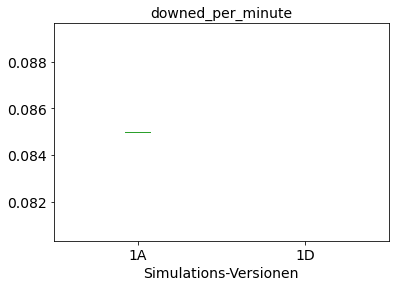

,1A,1D
0,0.0,0.0
1,0.084986,0.0
2,0.0,0.0


                     25
atpqp Profile-Visual  0
hnkgs Profile-Visual  1
twkfm Profile-Visual  0
                                         25
atpqp Profile-Visual+Weste+Thermal+Sound  0
hnkgs Profile-Visual+Weste+Thermal+Sound  0
twkfm Profile-Visual+Weste+Thermal+Sound  0


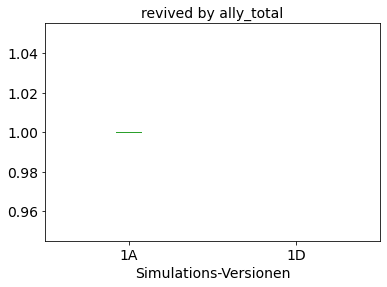

,1A,1D
0,0,0
1,1,0
2,0,0


                            26
atpqp Profile-Visual       0.0
hnkgs Profile-Visual  0.084986
twkfm Profile-Visual       0.0
                                           26
atpqp Profile-Visual+Weste+Thermal+Sound  0.0
hnkgs Profile-Visual+Weste+Thermal+Sound  0.0
twkfm Profile-Visual+Weste+Thermal+Sound  0.0


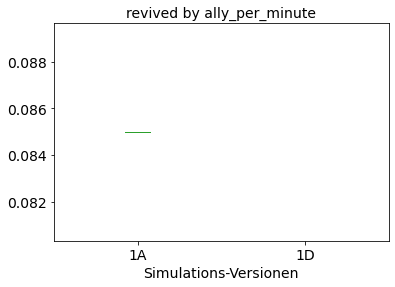

,1A,1D
0,0.0,0.0
1,0.084986,0.0
2,0.0,0.0


                      27
atpqp Profile-Visual  18
hnkgs Profile-Visual  19
twkfm Profile-Visual  14
                                          27
atpqp Profile-Visual+Weste+Thermal+Sound   9
hnkgs Profile-Visual+Weste+Thermal+Sound  11
twkfm Profile-Visual+Weste+Thermal+Sound  14


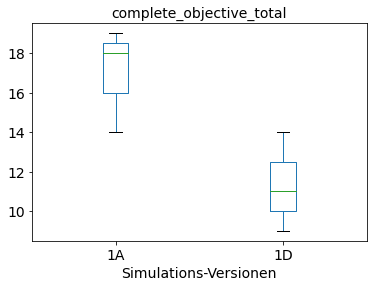

,1A,1D
0,18,9
1,19,11
2,14,14


                            28
atpqp Profile-Visual  1.190739
hnkgs Profile-Visual  1.614731
twkfm Profile-Visual  1.150685
                                                28
atpqp Profile-Visual+Weste+Thermal+Sound  0.573248
hnkgs Profile-Visual+Weste+Thermal+Sound  0.960699
twkfm Profile-Visual+Weste+Thermal+Sound  0.990566


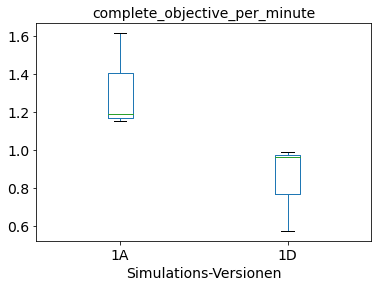

,1A,1D
0,1.190739,0.573248
1,1.614731,0.960699
2,1.150685,0.990566


                      29
atpqp Profile-Visual  19
hnkgs Profile-Visual  20
twkfm Profile-Visual  15
                                          29
atpqp Profile-Visual+Weste+Thermal+Sound   9
hnkgs Profile-Visual+Weste+Thermal+Sound  12
twkfm Profile-Visual+Weste+Thermal+Sound  15


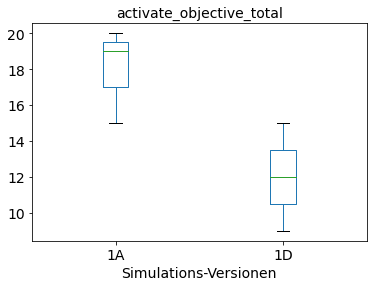

,1A,1D
0,19,9
1,20,12
2,15,15


                            30
atpqp Profile-Visual  1.256891
hnkgs Profile-Visual  1.699717
twkfm Profile-Visual  1.232877
                                                30
atpqp Profile-Visual+Weste+Thermal+Sound  0.573248
hnkgs Profile-Visual+Weste+Thermal+Sound  1.048035
twkfm Profile-Visual+Weste+Thermal+Sound  1.061321


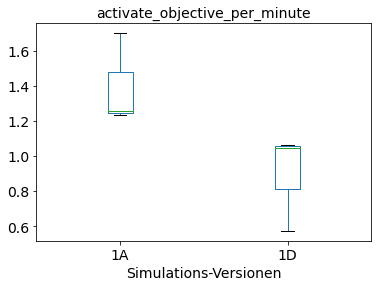

,1A,1D
0,1.256891,0.573248
1,1.699717,1.048035
2,1.232877,1.061321


                              31
atpqp Profile-Visual  433.178689
hnkgs Profile-Visual  396.030848
twkfm Profile-Visual  457.255051
                                                  31
atpqp Profile-Visual+Weste+Thermal+Sound  458.811475
hnkgs Profile-Visual+Weste+Thermal+Sound  449.710145
twkfm Profile-Visual+Weste+Thermal+Sound  453.746237


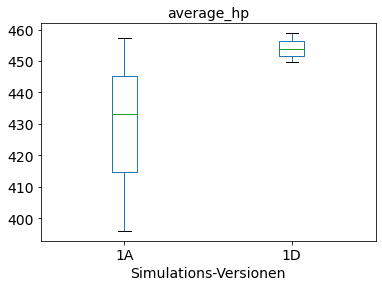

,1A,1D
0,433.178689,458.811475
1,396.030848,449.710145
2,457.255051,453.746237


                             32
atpqp Profile-Visual  64.437705
hnkgs Profile-Visual   56.27892
twkfm Profile-Visual  75.931818
                                                 32
atpqp Profile-Visual+Weste+Thermal+Sound  73.206967
hnkgs Profile-Visual+Weste+Thermal+Sound  67.902174
twkfm Profile-Visual+Weste+Thermal+Sound  74.655914


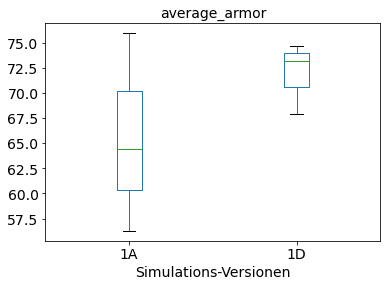

,1A,1D
0,64.437705,73.206967
1,56.27892,67.902174
2,75.931818,74.655914


                        33
atpqp Profile-Visual  1593
hnkgs Profile-Visual  1808
twkfm Profile-Visual  1098
                                            33
atpqp Profile-Visual+Weste+Thermal+Sound  1249
hnkgs Profile-Visual+Weste+Thermal+Sound  1583
twkfm Profile-Visual+Weste+Thermal+Sound  1145


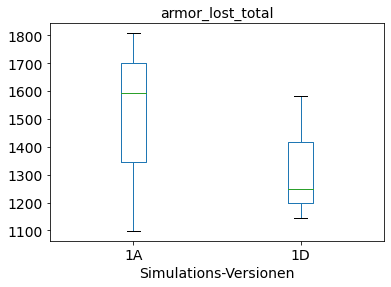

,1A,1D
0,1593,1249
1,1808,1583
2,1098,1145


                              34
atpqp Profile-Visual  105.380375
hnkgs Profile-Visual  153.654391
twkfm Profile-Visual   90.246575
                                                  34
atpqp Profile-Visual+Weste+Thermal+Sound    79.55414
hnkgs Profile-Visual+Weste+Thermal+Sound  138.253275
twkfm Profile-Visual+Weste+Thermal+Sound   81.014151


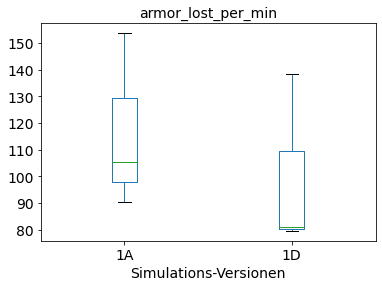

,1A,1D
0,105.380375,79.55414
1,153.654391,138.253275
2,90.246575,81.014151


                       35
atpqp Profile-Visual  398
hnkgs Profile-Visual  770
twkfm Profile-Visual   97
                                           35
atpqp Profile-Visual+Weste+Thermal+Sound   80
hnkgs Profile-Visual+Weste+Thermal+Sound  388
twkfm Profile-Visual+Weste+Thermal+Sound  137


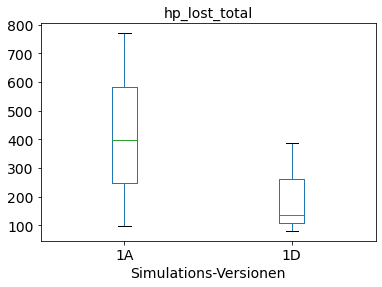

,1A,1D
0,398,80
1,770,388
2,97,137


                             36
atpqp Profile-Visual  26.328556
hnkgs Profile-Visual  65.439093
twkfm Profile-Visual   7.972603
                                                 36
atpqp Profile-Visual+Weste+Thermal+Sound   5.095541
hnkgs Profile-Visual+Weste+Thermal+Sound  33.886463
twkfm Profile-Visual+Weste+Thermal+Sound   9.693396


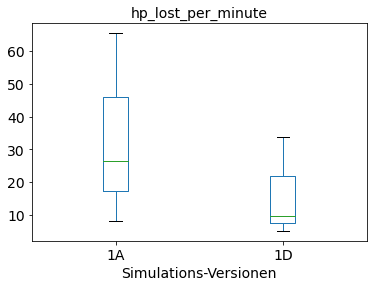

,1A,1D
0,26.328556,5.095541
1,65.439093,33.886463
2,7.972603,9.693396


                       37
atpqp Profile-Visual  415
hnkgs Profile-Visual  254
twkfm Profile-Visual  254
                                           37
atpqp Profile-Visual+Weste+Thermal+Sound  490
hnkgs Profile-Visual+Weste+Thermal+Sound  219
twkfm Profile-Visual+Weste+Thermal+Sound  393


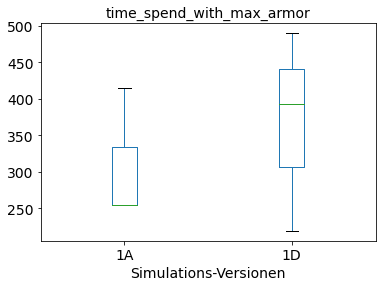

,1A,1D
0,415,490
1,254,219
2,254,393


                             38
atpqp Profile-Visual  45.755237
hnkgs Profile-Visual  35.977337
twkfm Profile-Visual  34.794521
                                                 38
atpqp Profile-Visual+Weste+Thermal+Sound  52.016985
hnkgs Profile-Visual+Weste+Thermal+Sound  31.877729
twkfm Profile-Visual+Weste+Thermal+Sound   46.34434


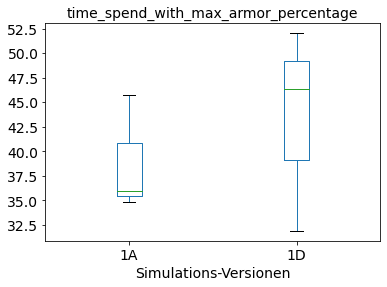

,1A,1D
0,45.755237,52.016985
1,35.977337,31.877729
2,34.794521,46.34434


                       39
atpqp Profile-Visual  110
hnkgs Profile-Visual    0
twkfm Profile-Visual   33
                                          39
atpqp Profile-Visual+Weste+Thermal+Sound  26
hnkgs Profile-Visual+Weste+Thermal+Sound   4
twkfm Profile-Visual+Weste+Thermal+Sound  40


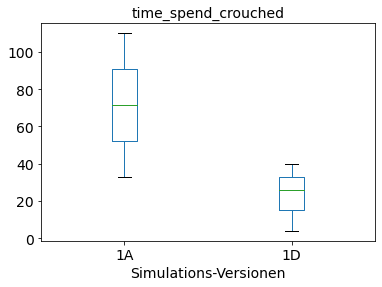

,1A,1D
0,110,26
1,0,4
2,33,40


                             40
atpqp Profile-Visual  12.127894
hnkgs Profile-Visual        0.0
twkfm Profile-Visual   4.520548
                                                40
atpqp Profile-Visual+Weste+Thermal+Sound  2.760085
hnkgs Profile-Visual+Weste+Thermal+Sound  0.582242
twkfm Profile-Visual+Weste+Thermal+Sound  4.716981


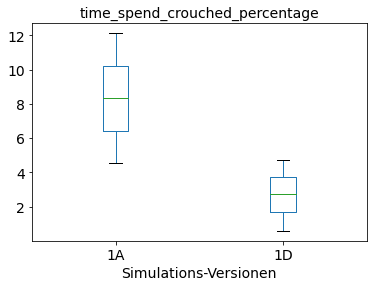

,1A,1D
0,12.127894,2.760085
1,0.0,0.582242
2,4.520548,4.716981


In [9]:
def plot_first_played(my_df, stat_name = "time_spend_crouched"):
    stat_by_profile = pd.DataFrame()
    # join all the versions, ignores which one was started with
    #https://thispointer.com/pandas-select-columns-based-on-conditions-in-dataframe/
    averages_df = pd.DataFrame()
    averages_df["stat"] = stats_df["stat"].drop([0,1])

    for p in ["Profile-Visual", "Profile-Visual+Weste+Thermal+Sound"]:
        filter_ = (stats_df == p).any()
        sub_df = stats_df.loc[:,filter_]
        
        starts_with_this_profile_filter = (sub_df == players_who_played_version_first[0]).any()
        for i in range(1,len(players_who_played_version_first)):
            starts_with_this_profile_filter = starts_with_this_profile_filter | (sub_df == players_who_played_version_first[i]).any()
        sub_df = sub_df.loc[:,starts_with_this_profile_filter]
        
        sub_df = sub_df.drop([0,1]) # dont need player tag and profile anymore
        # sub_df contains all playsessions of profile p

        row_of_stat = sub_df.loc[my_df["stat"]==stat_name] # get just the row for the stat we want to visualize
        column_of_stat = row_of_stat.transpose()
        print(column_of_stat)
        l = np.array(column_of_stat[column_of_stat.columns[0]])
        stat_by_profile['1'+short_name[p]] = l
        #print(stat_by_profile)
        
    ax = stat_by_profile.mask(stat_by_profile == 0).plot.box(fontsize = 14,)
    plt.suptitle('')
    ax.set_title(stat_name, fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    ax = plt.show()
    display(stat_by_profile)

#print(stats_df["stat"])
for stat in list(stats_df["stat"].drop([0,1])):
    plot_first_played(stats_df,stat)

In [10]:
df = pd.read_csv(os.path.join("questionnaire_stats", "variables_schmerz-simulation-pfeifer_2022-12-18_15-04_.csv"),sep = ",", encoding = 'UTF-8', keep_default_na = False)
keys = list(df["VAR"])
values = list(df["LABEL"])

v = {keys[i]: values[i] for i in range(len(keys))}

In [11]:
df = pd.read_csv(os.path.join("questionnaire_stats", "data_schmerz-simulation-pfeifer_2022-12-18_15-03_.csv"),sep = ",", encoding = 'UTF-8', keep_default_na = False)
data = df.loc[:,'BA01_01':'V002_01']
data["QUESTNNR"] = df["QUESTNNR"].replace(['base'], 'ABCD')
data["P102_01"] = data["P102_01"].apply(lambda row: row.lower())
data

,BA01_01,BA02_01,BA03_01,BA04_01,BA05_01,BA05_02,BA05_07,BA06_01,BA06_03,BA06_04,...,IF02_03,IF02_04,IF03_01,IF04_01,IF05_01,IF06_01,IF07_01,P102_01,V002_01,QUESTNNR
0,5,5,1,1,5,7,7,1,7,1,...,7,1,eher keine sobald vibration da war,richtung und häufigkeit,hilfreich bei hoher häufigkeit,hat nerven gekostet.<br>konnte man aber ausble...,7,dycnh,,ABCD
1,1,5,1,1,1,5,3,1,6,1,...,3,5,Leider eher wenig weil ich es nicht so aktiv m...,Durch die Vibrationsveste wusste ich genau wo ...,Das thermische Feedback hat mir mitgeteilt das...,Das auditive Feedback hat mir vorallem direkt ...,7,juheo,Hat sehr viel Spaß gemacht!,ABCD
2,6,6,6,5,5,6,4,4,5,5,...,6,7,Wie viel Schaden ich bekommen habe.,Die information von wo ich angeschossen wurde ...,Das ich mich zurückziehen muss.,das ich einmal getroffen wurde was gut passte ...,4,auffz,Das auditive feedback könnte einen etwas härte...,ABCD
3,4,5,1,1,3,6,3,4,5,3,...,5,4,Ich wurde angeschossen<br>,Von wo wurde ich angeschossen,ich wurde zu viel angegriffen,Ich wurde angeschossen,6,yicwd,Sehr cooles Prinzip<br>Hätte nicht gedacht das...,CDAB
4,6,6,5,6,3,7,1,5,5,5,...,6,4,-Wenn ich Schaden bekommen habe<br>-Wenn ich ...,-Wo sind die Gegner,-Wenn ich zu viele Schaden bekommen habe,-Auditives Feedback war (im Vergleich zu ande...,7,hnkgs,,DABC
5,3,2,1,1,2,6,3,1,6,2,...,7,6,Grobe Richtung der Schadensquelle<br>Stärke de...,Genaue Richtung der Schadensquelle<br><br>Ob i...,Ob ich viel Schaden erlitten habe,Ob meine Rüstung intakt ist oder nicht<br>Welc...,5,twkfm,Mit der Weste getasert zu werden ist sehr inte...,DABC
6,4,3,2,3,1,6,5,2,3,2,...,6,2,Ungefähre Anzahl der Gegner und wellche Art vo...,Wann ich angeschossen werde wieviele Schüsse m...,Signal wenn ich zu viel Schaden erleide,Wenn ich angeschossen werde,4,lnlqi,,BCDA
7,4,3,1,1,2,6,1,2,2,1,...,1,1,Wie viele Gegner von wo ob ich getroffen worde...,Richtung der Gegner wenn ich sie nicht schon g...,das ich viele treffer ab Bekommen habe,das ich getroffen wurde,4,zegfw,Eine normale Runde zum start hatte mich nicht ...,BCDA
8,1,2,1,1,2,7,2,2,1,1,...,7,3,Nur um zu wissen wo ich hin muss und wenn ich ...,Dadurch konnte ich sehr gut wissen von wo ich ...,Das thermische Feedback war das spieleingreife...,Leider merkte ich keinen Unterschied (vielleic...,6,easva,Weste: Die Sensoren fühlen sich mehr wie eine ...,CDAB
9,5,3,2,1,3,5,6,3,4,2,...,6,2,Wenig sie sind mir kaum aufgefallen.,Viele vorallem der Taser war sehr eindeutig. D...,Das Feedback war am stärksten was sinn macht w...,Kaum ich habe es nicht wirklich wahr genommen ...,3,atpqp,,DABC


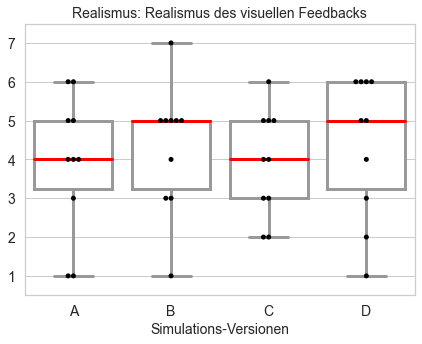

,BA01_01,BB01_01,BC01_01,BD01_01
0,5,5,2,2
1,1,5,4,4
2,6,7,6,6
3,4,5,5,6
4,6,5,5,6
5,3,3,2,5
6,4,5,5,5
7,4,3,3,3
8,1,1,4,1
9,5,4,3,6


___________________________


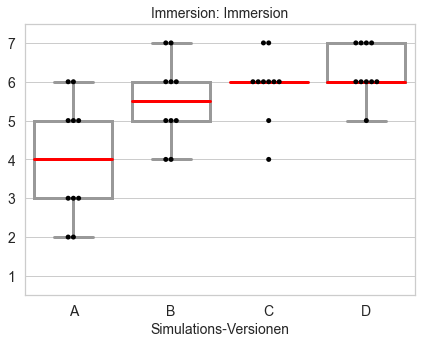

,BA02_01,BB02_01,BC02_01,BD02_01
0,5,7,7,5
1,5,4,4,7
2,6,7,7,7
3,5,5,6,7
4,6,6,6,6
5,2,5,6,6
6,3,5,6,6
7,3,6,6,6
8,2,4,5,6
9,3,6,6,7


___________________________


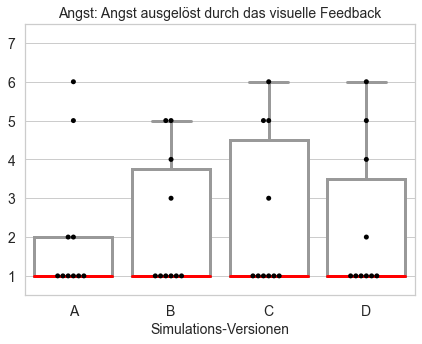

,BA03_01,BB03_01,BC03_01,BD03_01
0,1,1,1,1
1,1,1,1,1
2,6,5,5,5
3,1,1,1,1
4,5,5,5,1
5,1,1,1,2
6,2,4,6,4
7,1,1,1,1
8,1,1,1,1
9,2,3,3,6


___________________________


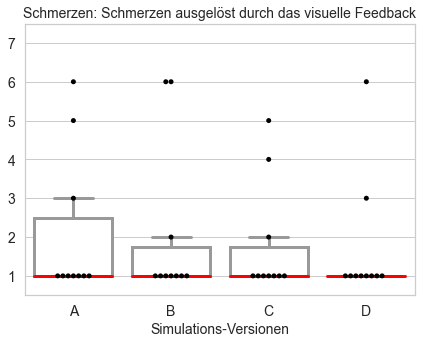

,BA04_01,BB04_01,BC04_01,BD04_01
0,1,1,1,1
1,1,1,1,1
2,5,6,5,6
3,1,1,1,1
4,6,6,4,1
5,1,1,1,1
6,3,2,2,3
7,1,1,1,1
8,1,1,1,1
9,1,1,1,1


___________________________


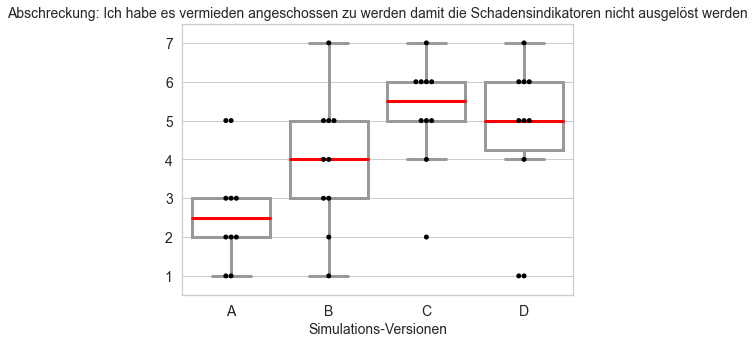

,BA05_01,BB05_01,BC05_01,BD05_01
0,5,4,2,1
1,1,5,5,5
2,5,7,7,7
3,3,3,6,5
4,3,1,5,1
5,2,5,6,5
6,1,3,5,4
7,2,4,6,6
8,2,5,6,6
9,3,2,4,6


___________________________


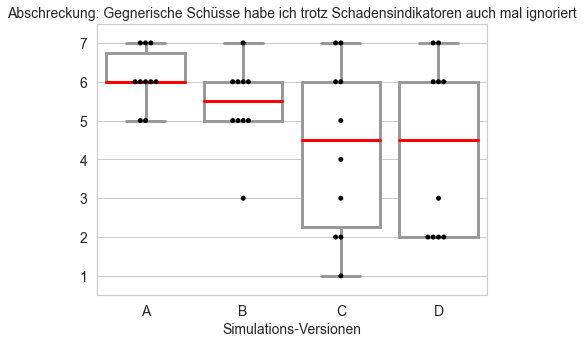

,BA05_02,BB05_02,BC05_02,BD05_02
0,7,5,7,7
1,5,3,1,2
2,6,6,2,2
3,6,5,2,2
4,7,7,7,6
5,6,5,4,6
6,6,6,6,6
7,6,5,3,2
8,7,6,6,7
9,5,6,5,3


___________________________


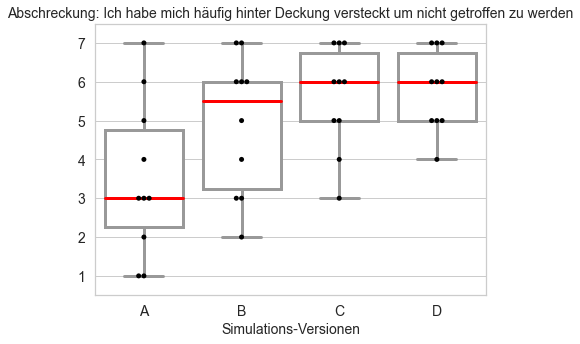

,BA05_07,BB05_07,BC05_07,BD05_07
0,7,7,7,7
1,3,4,5,4
2,4,7,7,6
3,3,3,4,5
4,1,3,3,5
5,3,6,6,7
6,5,6,6,6
7,1,2,5,5
8,2,6,7,7
9,6,5,6,6


___________________________


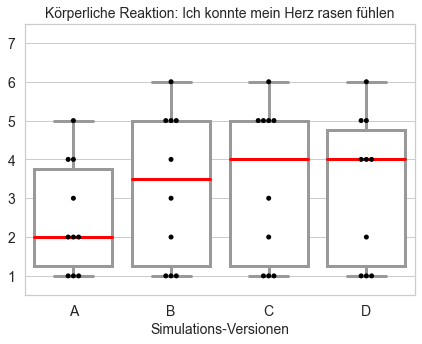

,BA06_01,BB06_01,BC06_01,BD06_01
0,1,1,1,1
1,1,1,1,1
2,4,5,5,5
3,4,4,5,5
4,5,5,5,4
5,1,1,1,1
6,2,5,5,4
7,2,6,6,6
8,2,2,3,2
9,3,3,2,4


___________________________


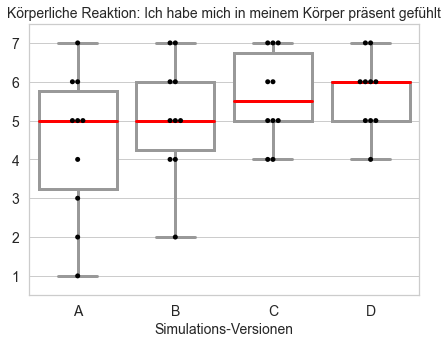

,BA06_03,BB06_03,BC06_03,BD06_03
0,7,7,7,7
1,6,5,6,6
2,5,7,7,7
3,5,5,5,5
4,5,6,7,6
5,6,4,4,5
6,3,5,5,5
7,2,4,4,4
8,1,2,5,6
9,4,6,6,6


___________________________


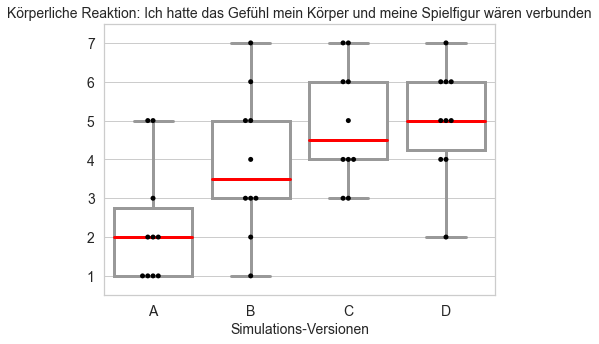

,BA06_04,BB06_04,BC06_04,BD06_04
0,1,3,3,2
1,1,1,3,5
2,5,7,7,7
3,3,3,4,6
4,5,5,6,5
5,2,5,5,6
6,2,3,6,5
7,1,4,4,4
8,1,2,4,4
9,2,6,7,6


___________________________


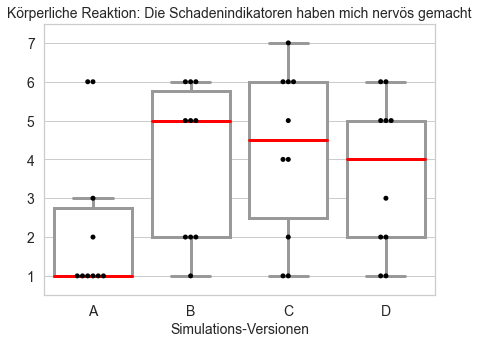

,BA06_05,BB06_05,BC06_05,BD06_05
0,1,2,1,1
1,1,2,1,2
2,6,6,7,6
3,1,1,2,1
4,6,5,5,2
5,1,6,4,5
6,2,6,6,3
7,1,5,6,5
8,1,2,6,5
9,3,5,4,6


___________________________


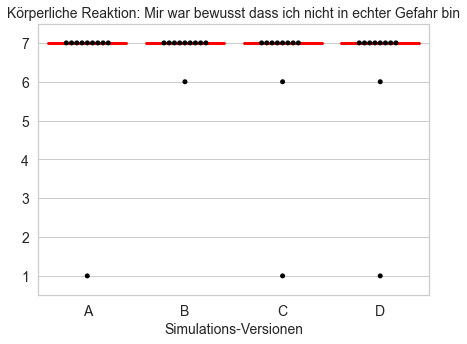

,BA06_06,BB06_06,BC06_06,BD06_06
0,7,7,7,7
1,7,7,7,7
2,7,7,7,7
3,7,7,7,7
4,7,6,6,6
5,7,7,7,7
6,7,7,7,7
7,1,7,1,1
8,7,7,7,7
9,7,7,7,7


___________________________


OSError: [Errno 22] Invalid argument: 'plot_Spaß_ Wie viel Spaß hat dir das Spiel mit den Schadensindikatoren gemacht?.png'

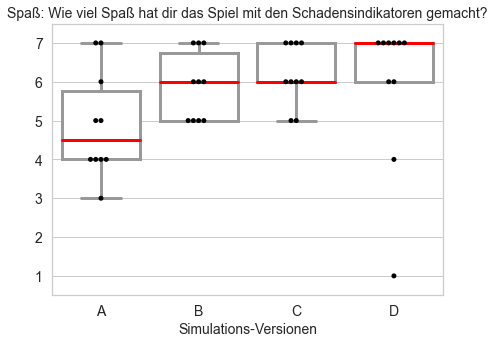

In [74]:
import seaborn as sns

def plot_questionnaire(data, column ):
    
    fig, ax=plt.subplots(figsize=(10,7))
    ax = data.boxplot(fontsize = 14,column= column, boxprops=dict(linestyle='-', linewidth=1.5),
             flierprops=dict(linestyle='-', linewidth=1.5),
             medianprops=dict(linestyle='-', linewidth=3),
             whiskerprops=dict(linestyle='-', linewidth=1.5),
             capprops=dict(linestyle='-', linewidth=1.5),
             showfliers=False, grid=True)
    ax.set_title(v[column[0]], fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    ax.set_ylim([0.5,7.5])
    
    sns.swarmplot(ax=ax, order = column, data = data)
    
    #ax.set_xticklabels(["A","B","C","D"])
    
    
    ax = plt.show()
    display(data.loc[:,column])
    
    
    print()

def plot_questionnaire_sns(dataa, column ):
    
    fig, ax=plt.subplots(figsize=(7,5))
    sns.set(style = "whitegrid")
    sns.boxplot(order = column, data=dataa, showfliers = False, color = "white", medianprops={"color": "red"}, showmeans=False, 
                     meanprops={"marker":"o", "markerfacecolor":"white", "markeredgecolor":"black","markersize":"10"}, linewidth = 3, ax = ax)
    sns.swarmplot(order = column, data = dataa, ax = ax, color = "black")
    ax.set_title(v[column[0]], fontsize = 14);
    ax.set_xlabel("Simulations-Versionen", fontsize = 14);
    ax.set_ylabel("");
    ax.set_ylim([0.5,7.5])
    ax.set_xticklabels(["A","B","C","D"])
    
    plt.tick_params(axis='both', which='major', labelsize=14)
    #n = "plot_"+v[column[0]]+".png"
    #print(n)
    plt.savefig(f"plot_{v[column[0]].replace(':', '_')}.png")
    plt.show()
    display(data.loc[:,column])
    print("___________________________")

befragung = [c for c in data.columns if "BA" in c]
for var in befragung:
    plot_questionnaire_sns(data, [var, var.replace('A','B'), var.replace('A','C'),var.replace('A','D')])


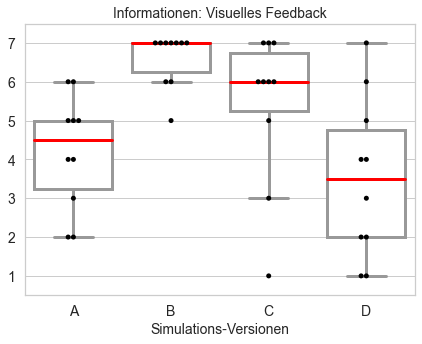

,IF02_01,IF02_02,IF02_03,IF02_04
0,5,7,7,1
1,4,7,3,5
2,6,7,6,7
3,3,7,5,4
4,5,7,6,4
5,4,6,7,6
6,5,6,6,2
7,6,5,1,1
8,2,7,7,3
9,2,7,6,2


___________________________


In [63]:
plot_questionnaire_sns(data, ["IF02_01", "IF02_02","IF02_03","IF02_04"])
# am meisten informationen über weste. auch einiges über thermisches feedback
# weste feedback haben alle außer einer person haben 7 gesagt. eine hat 5 gesagt.
# thermisches feedback viele sehr hoch bewerten zwischen 7 und 5. wenige haben es als niedrig bewertet. 

ValueError: The number of FixedLocator locations (1), usually from a call to set_ticks, does not match the number of ticklabels (4).

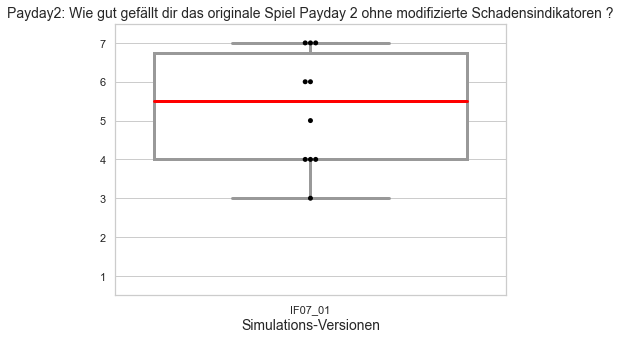

In [64]:
plot_questionnaire_sns(data, ["IF07_01"])

,IF01_01,IF01_02,IF01_03,IF01_04,IF01_06
0,1,1,2,2,1
1,1,2,2,2,1
2,2,1,2,2,1
3,1,1,2,2,1
4,1,1,2,1,1
5,1,2,2,2,1
6,1,1,2,2,1
7,1,1,2,2,1
8,1,1,2,2,1
9,1,1,2,1,1


ValueError: The number of FixedLocator locations (5), usually from a call to set_ticks, does not match the number of ticklabels (4).

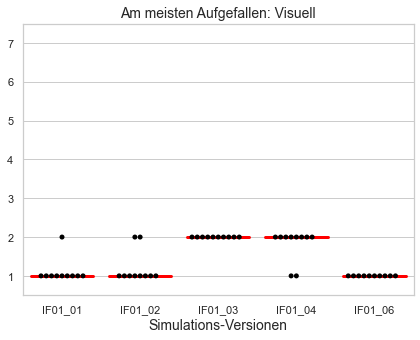

In [66]:
# welche sind am meisten aufgefallen? 
column = ["IF01_01", "IF01_02", "IF01_03", "IF01_04", "IF01_06"]
display(data.loc[:,column])
plot_questionnaire_sns(data, column)
# visual, auditory, vibration, thermal, nichts
#count of these